In [1]:
from glob import glob
import json
import pandas as pd
from tqdm import tqdm
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to use Type 42 fonts
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

path = "../.."
dataset = "1100"

In [2]:
jsons = glob(f"{path}/seqfiles_{dataset}/*/seq.json")

In [3]:
data = []
for json_file in tqdm(jsons, desc="Processing JSON files"):
    folder_name = os.path.basename(os.path.dirname(json_file))
    try:
        with open(json_file) as f:
            json_data = json.load(f)
            p_value = json_data["test results"]["p-value"]
            lrt = json_data["test results"]["LRT"]
            data.append({'name': folder_name, 'p_value': p_value, 'lrt': lrt})
    except json.JSONDecodeError:
        continue

evolution = pd.DataFrame(data)


Processing JSON files: 100%|██████████| 1285/1285 [03:14<00:00,  6.61it/s]


In [4]:
# Calculate the number of genes with evidence for positive selection
# We consider p-value < 0.05 as evidence for positive selection
# Filter out rows with NaN p-values (which could be from empty files)
valid_p_values = evolution['p_value'].dropna()
num_positive_selection = (valid_p_values < 0.05).sum()

# Calculate the percentage of genes with evidence for positive selection
percent_positive_selection = (num_positive_selection / len(valid_p_values)) * 100

print(f"Number of genes with evidence for positive selection: {num_positive_selection}")
print(f"Percentage of genes with evidence for positive selection: {percent_positive_selection:.2f}%")
print(f"Total number of genes with valid p-values: {len(valid_p_values)}")
print(f"Number of genes with missing p-values: {len(evolution) - len(valid_p_values)}")

Number of genes with evidence for positive selection: 438
Percentage of genes with evidence for positive selection: 34.65%
Total number of genes with valid p-values: 1264
Number of genes with missing p-values: 0


In [5]:
evolution["name"] = evolution["name"].str.replace("_ASSOCIATED_WITH", ":ASSOCIATEDWITH")
evolution["name"] = evolution["name"].str.replace("_GROWS_ON", ":GROWSON")
evolution["name"] = evolution["name"].str.replace("_INHIBITS", ":INHIBITS")
evolution["name"] = evolution["name"].str.replace("_INHABITS", ":INHABITS")
evolution["name"] = evolution["name"].str.replace("_INFECTS", ":INFECTS")
evolution["name"] = evolution["name"].str.replace("_PRESENTS", ":PRESENTS")
evolution["name"] = evolution["name"].str.replace("_DEGRADES", ":DEGRADES")
evolution["name"] = evolution["name"].str.replace("_PRODUCES", ":PRODUCES")
evolution["name"] = evolution["name"].str.replace("_PROMOTES", ":PROMOTES")
evolution["name"] = evolution["name"].str.replace("_RESISTS", ":RESISTS")
evolution

,name,p_value,lrt
0,first_STRAIN-COMPOUND:PRODUCES_succinic_acid,0.000000e+00,126.479243
1,first_STRAIN-COMPOUND:PRODUCES_d-gluconate,5.000000e-01,0.000000
2,first_STRAIN-COMPOUND:PRODUCES_r-,4.558871e-05,18.605407
3,first_STRAIN-COMPOUND:PRODUCES_flagellin,1.114270e-07,30.633498
4,first_STRAIN-EFFECT:PRESENTS_enhanced_biofilm_...,1.326656e-02,7.258724
...,...,...,...
1259,first_STRAIN-MEDIUM:GROWSON_bm2,1.770001e-08,34.313107
1260,first_STRAIN-COMPOUND:PRODUCES_mono-rhamnolipid,5.000000e-01,0.000000
1261,first_STRAIN-COMPOUND:RESISTS_triclosan,9.213614e-02,3.382682
1262,first_STRAIN-COMPOUND:RESISTS_nalidixic_acid,3.843542e-05,18.946768


In [6]:
evolution["gene"] = evolution.name.str.split("_",expand=True,n=2)[0]
evolution["rel"] = evolution.name.str.split("_",expand=True,n=2)[1]
evolution["ner"] = evolution.name.str.split("_",expand=True,n=2)[2]

In [7]:
evolution["rel"] = evolution["rel"].str.replace("ASSOCIATEDWITH","ASSOCIATED_WITH")
evolution["rel"] = evolution["rel"].str.replace("GROWSON","GROWS_ON")

In [8]:
# with open(f"{path}/xgboost/annotations{dataset}/binary.pkl", 'rb') as f:
# #with open(f"{path}/binary.pkl", 'rb') as f:
# 	d = pickle.load(f)
# rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"{path}/xgboost/annotations{dataset}/*.parquet")]
# l = []
# for rel in tqdm(rels):
# 	for i in range(len(d[rel])):
# 		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
# 		if len(s) > 0:
# 			importance_values = s.sort_values(ascending=False).values
# 			genes = s.sort_values(ascending=False).index.to_list()
# 			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
# 			accuracy = d[rel][i][1]
# 			ner = d[rel][i][0][0]
# 			for j in range(len(importance_values)):
# 				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy])
# df = pd.DataFrame(l, columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

In [9]:
# df.to_csv("evolution.csv")

In [12]:
df  = pd.read_csv("evolution_files/evolution.csv")

In [13]:
df.value_counts("rel")

rel
STRAIN-COMPOUND:PRODUCES          335415
COMPOUND-STRAIN:INHIBITS          257487
STRAIN-MEDIUM:GROWS_ON            254370
STRAIN-PHENOTYPE:PRESENTS         203464
STRAIN-EFFECT:PRESENTS            115553
STRAIN-COMPOUND:RESISTS            78399
STRAIN-EFFECT:PROMOTES             74950
STRAIN-ORGANISM:INFECTS            54128
STRAIN-DISEASE:INHIBITS            49858
STRAIN-ORGANISM:INHABITS           45032
STRAIN-COMPOUND:DEGRADES           21635
STRAIN-ISOLATE:INHABITS            17338
STRAIN-DISEASE:ASSOCIATED_WITH     14419
STRAIN-ORGANISM:INHIBITS           13914
STRAIN-SPECIES:INHIBITS             8463
STRAIN-ORGANISM:SYMBIONT_OF         3993
STRAIN-EFFECT:INHIBITS               819
Name: count, dtype: int64

In [14]:
df["ner"] = df.ner.str.replace(' ','_').str.replace("'",'').str.replace('(','_').str.replace(')','_')

In [15]:
df = df[df["importance_ranking"]==1]

In [16]:
all_merged = df.merge(evolution, on=["ner","rel"]).drop(columns="gene_y")

In [17]:
all_merged.sort_values("lrt",ascending=False).to_csv("positive_selection.csv",index=False)

In [18]:
all_merged

,Unnamed: 0,rel,ner,gene_x,importance_values,importance_ranking,accuracy,name,p_value,lrt
0,2642,STRAIN-DISEASE:ASSOCIATED_WITH,invasive_disease,Harbinger transposase-derived nuclease domain,80.022919,1.0,0.978723,first_STRAIN-DISEASE:ASSOCIATEDWITH_invasive_d...,9.181263e-02,3.389716
1,2820,STRAIN-DISEASE:ASSOCIATED_WITH,pneumonia,Nucleotidyl transferase domain,22.570614,1.0,0.989362,first_STRAIN-DISEASE:ASSOCIATEDWITH_pneumonia,0.000000e+00,90.867243
2,3189,STRAIN-DISEASE:ASSOCIATED_WITH,acquired_infections,"Uncharacterised protein family, inner membrane...",57.046097,1.0,0.989362,first_STRAIN-DISEASE:ASSOCIATEDWITH_acquired_i...,1.311617e-12,53.333195
3,15126,STRAIN-SPECIES:INHIBITS,p._aeruginosa,"Bacteriophage T4, Gp38, tail fibre assembly",17.940186,1.0,0.960754,first_STRAIN-SPECIES:INHIBITS_p._aeruginosa,5.000000e-01,0.000000
4,15361,STRAIN-SPECIES:INHIBITS,albicans,RICH domain,339.392090,1.0,0.993721,first_STRAIN-SPECIES:INHIBITS_albicans,4.197416e-01,0.349938
...,...,...,...,...,...,...,...,...,...,...
1250,1467904,STRAIN-MEDIUM:GROWS_ON,wxml,"Protein of unknown function, YrpD",6.853095,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_wxml,5.000000e-01,0.000000
1251,1468866,STRAIN-MEDIUM:GROWS_ON,bicarbonate,GNAT domain,3.583890,1.0,0.999843,first_STRAIN-MEDIUM:GROWSON_bicarbonate,5.000000e-01,0.000000
1252,1469180,STRAIN-MEDIUM:GROWS_ON,modified,Large-conductance mechanosensitive channel/and...,3.153642,1.0,0.999739,first_STRAIN-MEDIUM:GROWSON_modified,5.000000e-01,0.000000
1253,1469717,STRAIN-MEDIUM:GROWS_ON,solid_rice_medium,PepSY domain,9.954523,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_solid_rice_medium,5.000000e-01,0.000000


In [19]:
all_merged["-log10(p_value)"] = -1 * all_merged["p_value"].apply(np.log10)
all_merged["logLRT"] = all_merged["lrt"].apply(np.log10)
all_merged["log_imp"] = all_merged["importance_values"].apply(np.log10)

In [20]:
all_merged.sort_values("lrt",ascending=False).head(10)

,Unnamed: 0,rel,ner,gene_x,importance_values,importance_ranking,accuracy,name,p_value,lrt,-log10(p_value),logLRT,log_imp
42,102249,STRAIN-EFFECT:INHIBITS,fungal_growth,"Putative DNA-binding domain, bacteria",13.288205,1.0,0.941667,first_STRAIN-EFFECT:INHIBITS_fungal_growth,0.0,3310.696320,inf,3.519919,1.123466
782,963397,STRAIN-PHENOTYPE:PRESENTS,gram-,PASTA domain,84.140427,1.0,0.973149,first_STRAIN-PHENOTYPE:PRESENTS_gram-,0.0,2869.253327,inf,3.457769,1.925005
72,150898,STRAIN-COMPOUND:DEGRADES,xylan,"Pectinesterase, catalytic",28.056580,1.0,0.989979,first_STRAIN-COMPOUND:DEGRADES_xylan,0.0,2218.134683,inf,3.345988,1.448035
457,597599,COMPOUND-STRAIN:INHIBITS,chg,Protein of unknown function DUF1064,2.973893,1.0,0.999424,first_COMPOUND-STRAIN:INHIBITS_chg,0.0,2111.872574,inf,3.324668,0.473325
175,278323,STRAIN-COMPOUND:PRODUCES,teichoic_acid,LPXTG cell wall anchor domain,8.678674,1.0,0.999473,first_STRAIN-COMPOUND:PRODUCES_teichoic_acid,0.0,1993.196247,inf,3.299550,0.938453
784,965973,STRAIN-PHENOTYPE:PRESENTS,positive,"Sporulation transcription regulator WhiA, N-te...",113.629150,1.0,0.979467,first_STRAIN-PHENOTYPE:PRESENTS_positive,0.0,1919.445194,inf,3.283176,2.055490
785,967920,STRAIN-PHENOTYPE:PRESENTS,gram_-_positive,"GTP-binding protein OBG, C-terminal",58.307354,1.0,0.988093,first_STRAIN-PHENOTYPE:PRESENTS_gram_-_positive,0.0,1439.926178,inf,3.158340,1.765723
70,147676,STRAIN-COMPOUND:DEGRADES,cellulose,CBS domain,38.610161,1.0,0.982105,first_STRAIN-COMPOUND:DEGRADES_cellulose,0.0,998.908426,inf,2.999526,1.586702
1101,1379318,STRAIN-MEDIUM:GROWS_ON,bm,Solute-binding protein family 3/N-terminal dom...,6.176338,1.0,0.999426,first_STRAIN-MEDIUM:GROWSON_bm,0.0,890.029837,inf,2.949405,0.790731
450,594436,COMPOUND-STRAIN:INHIBITS,cfdc,Domain of unknown function DUF2147,7.570808,1.0,0.999424,first_COMPOUND-STRAIN:INHIBITS_cfdc,0.0,859.788828,inf,2.934392,0.879142


Top 10 genes with highest evidence for positive selection:
                                                 gene_x  \
42                Putative DNA-binding domain, bacteria   
782                                        PASTA domain   
72                            Pectinesterase, catalytic   
457                 Protein of unknown function DUF1064   
175                       LPXTG cell wall anchor domain   
784   Sporulation transcription regulator WhiA, N-te...   
785                 GTP-binding protein OBG, C-terminal   
70                                           CBS domain   
1101  Solute-binding protein family 3/N-terminal dom...   
450                  Domain of unknown function DUF2147   

                            rel              ner          lrt  \
42       STRAIN-EFFECT:INHIBITS    fungal_growth  3310.696320   
782   STRAIN-PHENOTYPE:PRESENTS            gram-  2869.253327   
72     STRAIN-COMPOUND:DEGRADES            xylan  2218.134683   
457    COMPOUND-STRAIN:INHIBITS

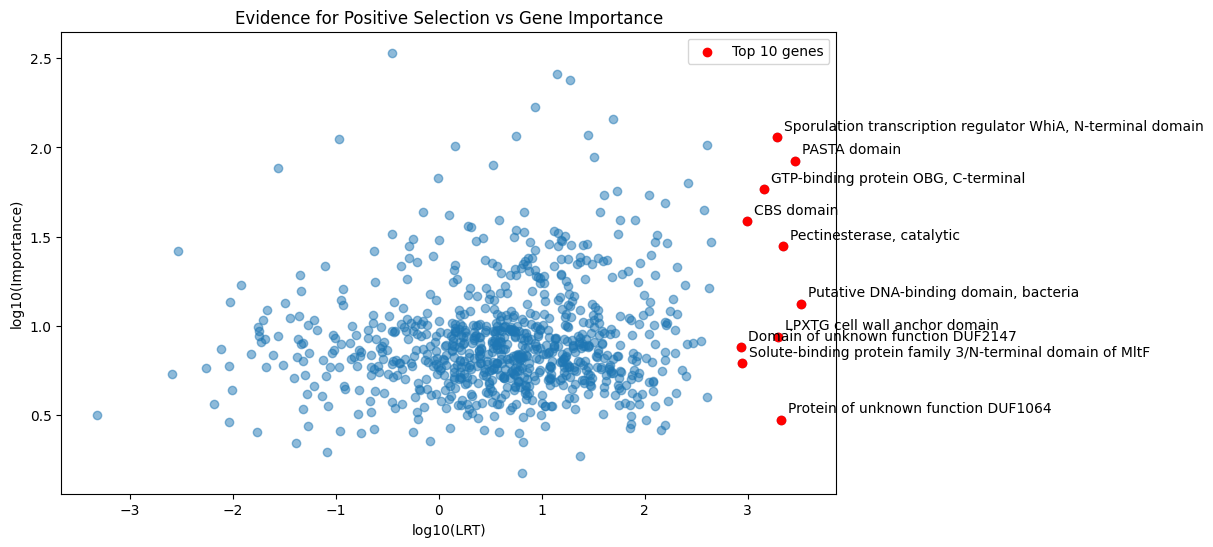

In [21]:
# Sort the dataframe by LRT in descending order and select top genes
top_genes = all_merged.sort_values("lrt", ascending=False).head(10)

# Display the top genes with highest evidence for positive selection
print("Top 10 genes with highest evidence for positive selection:")
print(top_genes[["gene_x", "rel", "ner", "lrt", "-log10(p_value)", "logLRT", "log_imp"]])

# Create a scatter plot of logLRT vs log_imp for visual representation
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(all_merged["logLRT"], all_merged["log_imp"], alpha=0.5)
plt.scatter(top_genes["logLRT"], top_genes["log_imp"], color="red", label="Top 10 genes")

for i, row in top_genes.iterrows():
    plt.annotate(row["gene_x"], (row["logLRT"], row["log_imp"]), xytext=(5, 5), textcoords="offset points")

plt.xlabel("log10(LRT)")
plt.ylabel("log10(Importance)")
plt.title("Evidence for Positive Selection vs Gene Importance")
plt.legend()
plt.show()


/scratch/slurm_tmpdir/job_24268283/ipykernel_289476/3595156499.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))


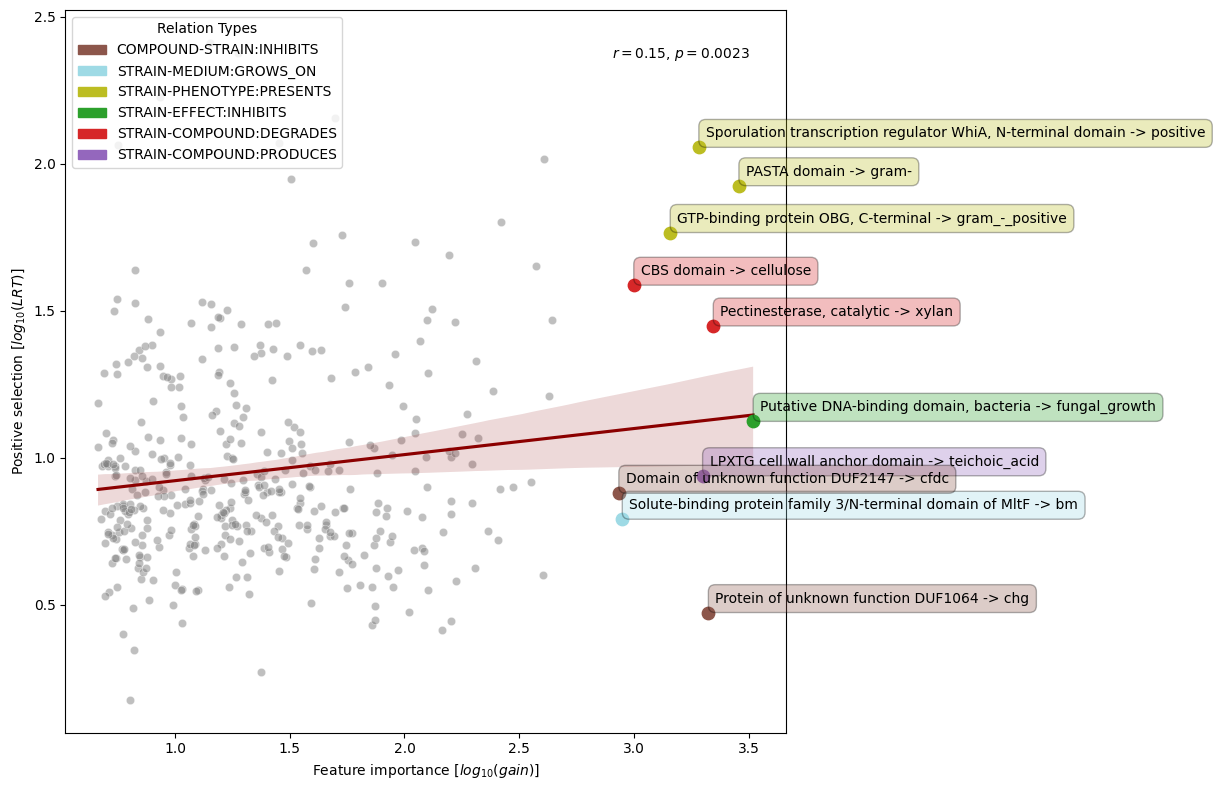

In [22]:
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the x and y values, filtering out np.nan values
filtered_data = all_merged[all_merged.p_value < 0.05].dropna(subset=['logLRT', 'log_imp'])
x = filtered_data['logLRT']
y = filtered_data['log_imp']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a color map for rel types
rel_types = filtered_data['rel'].unique()
color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))

# Create a scatter plot with regression line using seaborn
plt.figure(figsize=(12, 8))

# Plot all points in gray
sns.scatterplot(x=x, y=y, alpha=0.5, color='#808080')

# Plot regression line
sns.regplot(x=x, y=y, 
            scatter=False,
            line_kws={'color': '#8B0000'},  # Dark red line
            ci=95, 
            color='#8B0000')  # Dark red shade

# Annotate genes with higher evidence for positive selection
top_genes = filtered_data.nlargest(10, 'logLRT')
top_rels = set(top_genes['rel'])

# Plot top 10 points with colors based on relation type
for _, row in top_genes.iterrows():
    plt.scatter(row['logLRT'], row['log_imp'], color=color_map[row['rel']], s=80, zorder=3)  # Reduced size from 100 to 80
    plt.annotate(f"{row['gene_x']} -> {row['ner']}", 
                 xy=(row['logLRT'], row['log_imp']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 ha='left',
                 va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc=color_map[row['rel']], alpha=0.3),
                 zorder=4)

# Add the r value and p-value as text on the side
plt.text(0.95, 0.95, f'$r = ${r_value:.2f}, $p=${p_value:.2g}', 
         ha='right', va='top', transform=plt.gca().transAxes)

# Set the labels and title
plt.xlabel('Feature importance [$log_{10}(gain)$]')
plt.ylabel('Positive selection [$log_{10}(LRT)$]')

# Create legend only for rels found in top 10
legend_patches = [mpatches.Patch(color=color_map[rel], label=rel) for rel in top_rels]
plt.legend(handles=legend_patches, title='Relation Types', loc='upper left')

plt.tight_layout()

# Save the figure to a file as PDF
plt.savefig('figures/xgboost/feature_importance_vs_positive_selection.pdf', bbox_inches='tight')


In [23]:
linregress(x, y)

LinregressResult(slope=0.08865193266216945, intercept=0.83313583547513, rvalue=0.1459250890014914, pvalue=0.0023342655571009885, stderr=0.028949808959746293, intercept_stderr=0.042771912908233095)

/scratch/slurm_tmpdir/job_24268283/ipykernel_289476/1607130323.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))


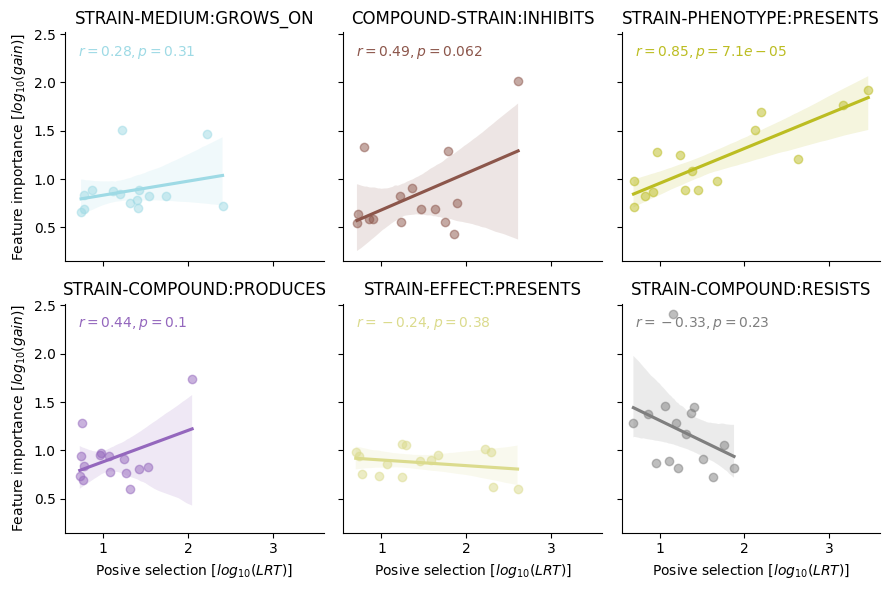

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.patches as mpatches

# Set the color palette to the accent color set
sns.set_palette("Dark2")

# Define the number of samples to use for each category
SAMPLES_PER_CATEGORY = 15

# Define the desired order for 'rel' categories
category_order = [
    "STRAIN-MEDIUM:GROWS_ON",
    "COMPOUND-STRAIN:INHIBITS",
    "STRAIN-PHENOTYPE:PRESENTS",
    "STRAIN-COMPOUND:PRODUCES",
    "STRAIN-EFFECT:PRESENTS",
    "STRAIN-COMPOUND:RESISTS",
    "STRAIN-EFFECT:PROMOTES",
    "STRAIN-ORGANISM:INFECTS",
    "STRAIN-DISEASE:INHIBITS",
    "STRAIN-ORGANISM:INHABITS",
    "STRAIN-COMPOUND:DEGRADES",
    "STRAIN-ISOLATE:INHABITS",
    "STRAIN-DISEASE:ASSOCIATED_WITH",
    "STRAIN-ORGANISM:INHIBITS",
    "STRAIN-SPECIES:INHIBITS",
    "STRAIN-ORGANISM:SYMBIONT_OF",
    "STRAIN-EFFECT:INHIBITS"
]

# Filter the dataset as per your conditions
filtered_data = all_merged[
    (all_merged.p_value < 0.05) & 
    (all_merged.rel.isin(category_order))
]

# Count the number of samples in each category
category_counts = filtered_data['rel'].value_counts()

# Keep only categories with at least SAMPLES_PER_CATEGORY samples
valid_categories = category_counts[category_counts >= SAMPLES_PER_CATEGORY].index.tolist()

# Update the category_order to include only valid categories
category_order = [cat for cat in category_order if cat in valid_categories]

# Subsample SAMPLES_PER_CATEGORY values from each valid category
subsampled_data = filtered_data[filtered_data['rel'].isin(valid_categories)].groupby('rel').apply(lambda x: x.sample(n=SAMPLES_PER_CATEGORY, random_state=42)).reset_index(drop=True)

# Initialize a dictionary to store regression results
regression_results = {}

# Calculate regression statistics for each 'rel' subset after removing infinite values
for rel in category_order:
    subset = subsampled_data[subsampled_data['rel'] == rel]
    
    # Remove rows with infinite values in 'logLRT' or 'log_imp'
    subset_clean = subset[np.isfinite(subset['logLRT']) & np.isfinite(subset['log_imp'])]
    
    if not subset_clean.empty:  # Only calculate if there's valid data
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(subset_clean['logLRT'], subset_clean['log_imp'])
        
        # Store results in the dictionary
        regression_results[rel] = {
            'r': r_value,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept
        }
    else:
        # Store None if the subset is empty after filtering
        regression_results[rel] = None

# Get the color map for the top 10 categories
rel_types = filtered_data['rel'].unique()
color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))

# Your code for plotting the dataframe
g = sns.lmplot(
    x="logLRT", 
    y="log_imp", 
    col="rel", 
    hue="rel", 
    data=subsampled_data, 
    aspect=1, 
    height=3, 
    scatter_kws={"alpha": 0.5},
    col_order=category_order,  # Set column order
    hue_order=category_order,  # Set hue order
    col_wrap=3,  # Wrap the columns after every 3 plots
    palette=color_map  # Use the color map for the categories
)

g.set_axis_labels("Posive selection [$log_{10}(LRT)$]", "Feature importance [$log_{10}(gain)$]")

# Add text annotations for each subplot and set titles
for ax, rel in zip(g.axes.flat, category_order):
    results = regression_results[rel]
    
    if results is not None:  # Only add text if there were valid results
        # Get the color used for the line plot
        line_color = color_map[rel]
        
        # Add text annotations for r and p-value
        ax.text(
            0.05, 0.95,  # X and Y positions (in axis units)
            f'$r = {results["r"]:.2f}, p = {results["p_value"]:.2g}$',
            transform=ax.transAxes,  # Use axis coordinates for positioning
            verticalalignment='top',  # Align text at the top
            color=line_color  # Use the same color as the line
        )

    # Set the title of each subplot 1to just the value of 'rel'
    ax.set_title(rel)

plt.tight_layout()
plt.savefig("figures/xgboost/positive_selection_latest.pdf", bbox_inches="tight")
plt.show()

/scratch/slurm_tmpdir/job_24268283/ipykernel_289476/3234912612.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))


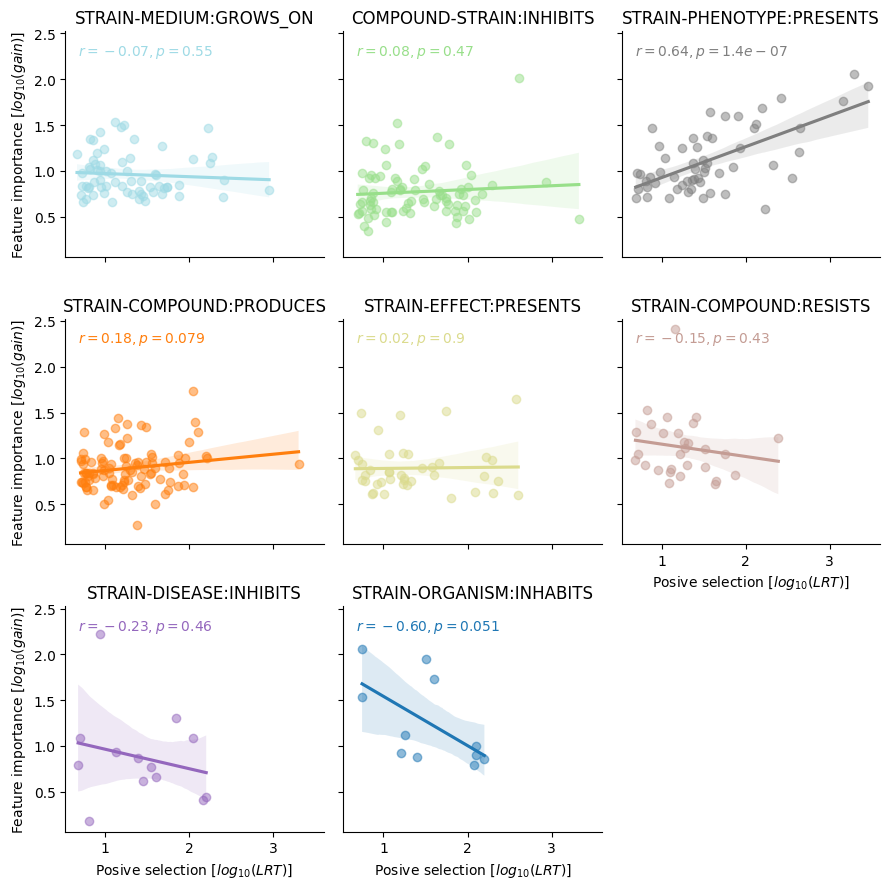

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.patches as mpatches

# Set the color palette to the accent color set
sns.set_palette("Dark2")

# Define the desired order for 'rel' categories
category_order = [
    "STRAIN-MEDIUM:GROWS_ON",
    "COMPOUND-STRAIN:INHIBITS",
    "STRAIN-PHENOTYPE:PRESENTS",
    "STRAIN-COMPOUND:PRODUCES",
    "STRAIN-EFFECT:PRESENTS",
    "STRAIN-COMPOUND:RESISTS",
    "STRAIN-EFFECT:PROMOTES",
    "STRAIN-ORGANISM:INFECTS",
    "STRAIN-DISEASE:INHIBITS",
    "STRAIN-ORGANISM:INHABITS",
    "STRAIN-COMPOUND:DEGRADES",
    "STRAIN-ISOLATE:INHABITS",
    "STRAIN-DISEASE:ASSOCIATED_WITH",
    "STRAIN-ORGANISM:INHIBITS",
    "STRAIN-SPECIES:INHIBITS",
    "STRAIN-ORGANISM:SYMBIONT_OF",
    "STRAIN-EFFECT:INHIBITS"
]

# Filter the dataset as per your conditions
filtered_data = all_merged[
    (all_merged.p_value < 0.05) & 
    (all_merged.rel.isin(category_order))
]

# Filter out categories with 10 or less entries
category_counts = filtered_data['rel'].value_counts()
valid_categories = category_counts[category_counts > 9].index.tolist()
filtered_data = filtered_data[filtered_data['rel'].isin(valid_categories)]

# Update category_order to only include valid categories
category_order = [cat for cat in category_order if cat in valid_categories]

# Initialize a dictionary to store regression results
regression_results = {}

# Calculate regression statistics for each 'rel' subset after removing infinite values
for rel in category_order:
    subset = filtered_data[filtered_data['rel'] == rel]
    
    # Remove rows with infinite values in 'logLRT' or 'log_imp'
    subset_clean = subset[np.isfinite(subset['logLRT']) & np.isfinite(subset['log_imp'])]
    
    if not subset_clean.empty:  # Only calculate if there's valid data
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(subset_clean['logLRT'], subset_clean['log_imp'])
        
        # Store results in the dictionary
        regression_results[rel] = {
            'r': r_value,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept
        }
    else:
        # Store None if the subset is empty after filtering
        regression_results[rel] = None

# Get the color map for the categories
rel_types = filtered_data['rel'].unique()
color_map = dict(zip(rel_types, plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(rel_types)))))

# Ensure all categories in category_order are present in color_map
for category in category_order:
    if category not in color_map:
        color_map[category] = plt.cm.get_cmap('tab20')(np.random.random())

# Your code for plotting the dataframe
g = sns.lmplot(
    x="logLRT", 
    y="log_imp", 
    col="rel", 
    hue="rel", 
    data=filtered_data, 
    aspect=1, 
    height=3, 
    scatter_kws={"alpha": 0.5},
    col_order=category_order,  # Set column order
    hue_order=category_order,  # Set hue order
    col_wrap=3,  # Wrap the columns after every 3 plots
    palette=color_map  # Use the color map for the categories
)

g.set_axis_labels("Posive selection [$log_{10}(LRT)$]", "Feature importance [$log_{10}(gain)$]")

# Add text annotations for each subplot and set titles
for ax, rel in zip(g.axes.flat, category_order):
    results = regression_results[rel]
    
    if results is not None:  # Only add text if there were valid results
        # Get the color used for the line plot
        line_color = color_map[rel]
        
        # Add text annotations for r and p-value
        ax.text(
            0.05, 0.95,  # X and Y positions (in axis units)
            f'$r = {results["r"]:.2f}, p = {results["p_value"]:.2g}$',
            transform=ax.transAxes,  # Use axis coordinates for positioning
            verticalalignment='top',  # Align text at the top
            color=line_color  # Use the same color as the line
        )

    # Set the title of each subplot to just the value of 'rel'
    ax.set_title(rel)

plt.tight_layout()
plt.savefig("figures/xgboost/positive_selection_latest.pdf", bbox_inches="tight")
plt.show()

In [26]:
subsampled_data.head(30).sort_values("logLRT",ascending=False)

,Unnamed: 0,rel,ner,gene_x,importance_values,importance_ranking,accuracy,name,p_value,lrt,-log10(p_value),logLRT,log_imp
1,523665,COMPOUND-STRAIN:INHIBITS,erythromycin,"Peptidase M26, C-terminal domain",103.304039,1.0,0.992219,first_COMPOUND-STRAIN:INHIBITS_erythromycin,0.000000e+00,407.645392,inf,2.610283,2.014117
24,172534,STRAIN-COMPOUND:PRODUCES,acetate,Ferrochelatase,54.084064,1.0,0.994061,first_STRAIN-COMPOUND:PRODUCES_acetate,0.000000e+00,111.507309,inf,2.047303,1.733069
0,602028,COMPOUND-STRAIN:INHIBITS,csa-13,Inner membrane protein RclC-like,5.653478,1.0,0.999481,first_COMPOUND-STRAIN:INHIBITS_csa-13,0.000000e+00,78.509557,inf,1.894923,0.752316
7,629291,COMPOUND-STRAIN:INHIBITS,furan,Protein of unknown function DUF6978,2.687796,1.0,0.999654,first_COMPOUND-STRAIN:INHIBITS_furan,1.110223e-16,72.535313,15.954590,1.860549,0.429396
2,592075,COMPOUND-STRAIN:INHIBITS,ars,tRNA nucleotidyltransferase/poly(A) polymerase...,19.599794,1.0,0.999366,first_COMPOUND-STRAIN:INHIBITS_ars,3.130829e-14,60.804432,13.504341,1.783935,1.292252
10,624415,COMPOUND-STRAIN:INHIBITS,trimeric_tob,"RNA-splicing ligase, RtcB",3.605888,1.0,0.999597,first_COMPOUND-STRAIN:INHIBITS_trimeric_tob,3.319012e-13,56.081677,12.478991,1.748821,0.557012
11,604334,COMPOUND-STRAIN:INHIBITS,ncl259,Sel1-like repeat,4.929132,1.0,0.999481,first_COMPOUND-STRAIN:INHIBITS_ncl259,2.995730e-10,42.471032,9.523497,1.628093,0.692770
29,376729,STRAIN-COMPOUND:PRODUCES,"2,5-dimethylpyrazine","Minor extracellular protease Epr, GA-like domain",6.754059,1.0,0.999761,"first_STRAIN-COMPOUND:PRODUCES_2,5-dimethylpyr...",2.087635e-08,33.983003,7.680345,1.531262,0.829565
3,602202,COMPOUND-STRAIN:INHIBITS,ha,"Dehydrogenase, E1 component",4.876863,1.0,0.999481,first_COMPOUND-STRAIN:INHIBITS_ha,2.256552e-07,29.222221,6.646555,1.465713,0.688141
22,354384,STRAIN-COMPOUND:PRODUCES,macrolide,"Polyketide synthase, dehydratase domain, N-ter...",6.366071,1.0,0.999713,first_STRAIN-COMPOUND:PRODUCES_macrolide,9.353636e-07,26.378367,6.029020,1.421248,0.803871


In [27]:
subsampled_data[["rel","ner","gene_x","logLRT","log_imp"]].sort_values("logLRT",ascending=False).head(5)

,rel,ner,gene_x,logLRT,log_imp
75,STRAIN-PHENOTYPE:PRESENTS,gram-,PASTA domain,3.457769,1.925005
86,STRAIN-PHENOTYPE:PRESENTS,gram_-_positive,"GTP-binding protein OBG, C-terminal",3.158340,1.765723
84,STRAIN-PHENOTYPE:PRESENTS,free,DegV,2.628078,1.211016
1,COMPOUND-STRAIN:INHIBITS,erythromycin,"Peptidase M26, C-terminal domain",2.610283,2.014117
50,STRAIN-EFFECT:PRESENTS,adsorption_capacity,N-(5'phosphoribosyl) anthranilate isomerase (P...,2.603563,0.602626
